In [133]:
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')



## Fig size 10,10
## subplot 2 by 2
## work on time series analysis for Net Income (and split by lower 4 banks)

Reading in data and add Total Net Income (not subdivided by bank size)

In [10]:
df = pd.read_csv('../data/banks_data_1984.csv')

In [54]:
USNIM = pd.read_csv('../data/USNIM.csv')

In [57]:
USNIM.DATE = pd.to_datetime(USNIM.DATE, infer_datetime_format=True)

In [58]:
USNIM.set_index('DATE', inplace = True)

In [63]:
df2 = df.merge(USNIM, how = 'left', left_index = True, right_index = True)

In [17]:
# Adding column that has total number of banks for a given quarter.

df['Tot_Num_Banks'] = df.US100NUM+df.US13NUM+df.US31NUM+df.US115NUM+df.USG15NUM

In [15]:
# Need to convert Date column info to datetime type.

df.DATE = pd.to_datetime(df.DATE, infer_datetime_format=True)

(141, 32)

In [19]:
# Make Date the index 
df.set_index('DATE', inplace = True)

## Looking at each variable over time

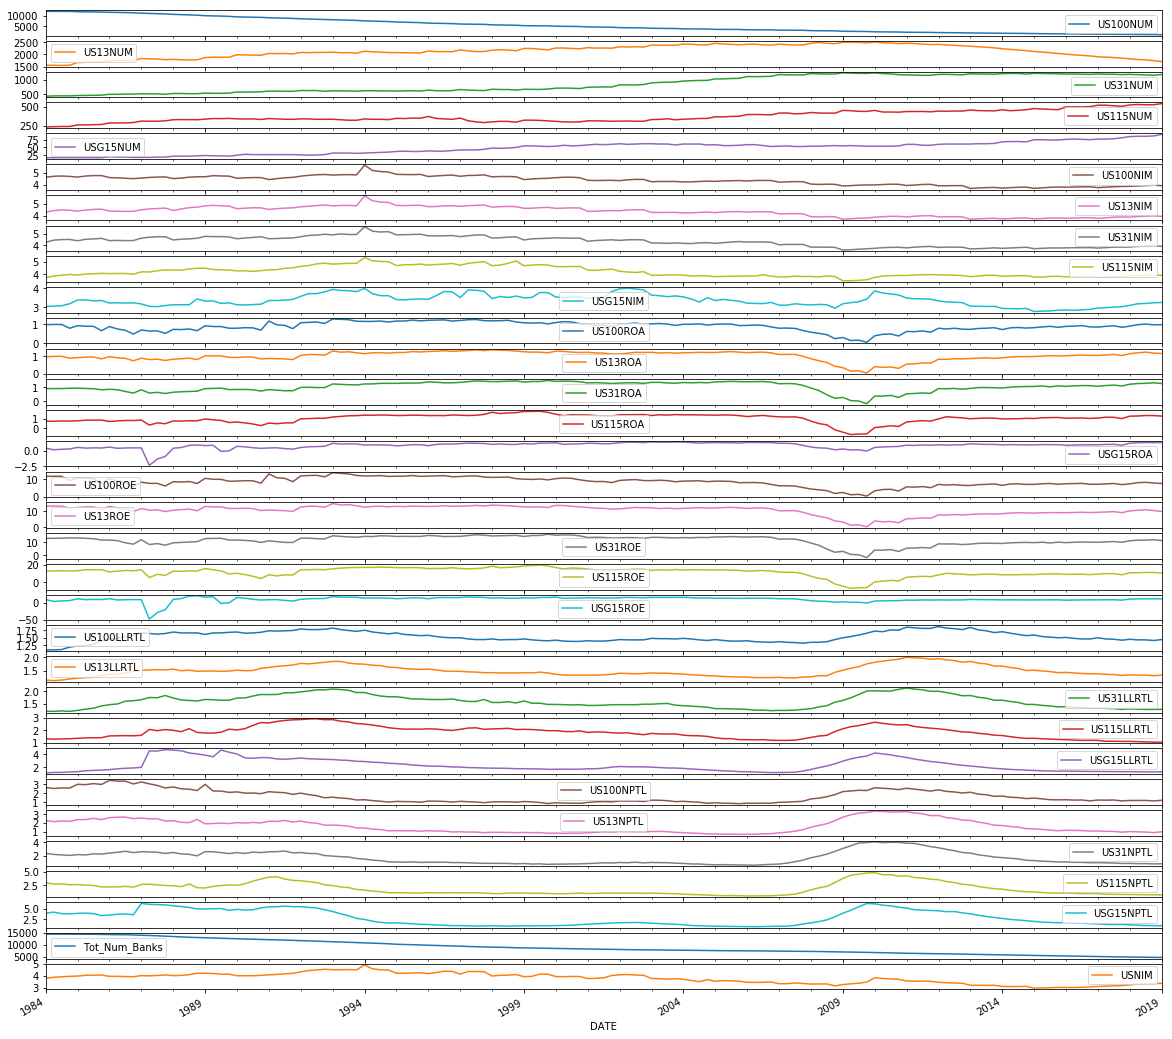

In [67]:
df2.plot(figsize = (20,20), subplots=True, legend=True)
plt.show()

In [49]:
# Use pandas grouper to group values using annual frequency
year_groups = df.groupby(pd.Grouper(freq ='A'))

## Come back to this

Trying to see subplots of variable by year

In [102]:
# df_annual = pd.DataFrame()

# for yr, group in year_groups:
#     print(group.values)
#     df_annual[yr.year] = group.values.ravel()

In [103]:
# Plot the yearly groups as subplots
# df_annual.plot(figsize = (22,15), subplots=True, legend=True)
# plt.show()

Moving on to seasonality and trend:

The Dickey Fuller Test is a statistical test for testing stationarity. The Null-hypothesis for the test is that the time series is not stationary. So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary. The Dickey Fuller test is available in stattools from the StatsModels module.

In [68]:
## Performing Dickey-Fuller test to assess whether there is a trend (the average is changing over time?)

from statsmodels.tsa.stattools import adfuller


In [70]:
df_US100NUM_test = adfuller(df2.US100NUM)

dfoutput = pd.Series(df_US100NUM_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_US100NUM_test[4].items():
    dfoutput['Critical Value (%s)'%key] = value

dfoutput   
    

Test Statistic                -5.780781e+00
p-value                        5.131950e-07
#Lags Used                     1.000000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64

Our p-value is very small (lower than a significance level of 5%) - therefore we should reject the null hypothesis - which would mean the US100NUM variable is stationary...BUT we can clearly see from the below graph/calculation that the mean is changing over time...there is a clear trend. 

What did I do wrong? 

In [71]:
rolmean = df2.US100NUM.rolling(window = 8, center = False).mean()
rolstd = df2.US100NUM.rolling(window = 8, center = False).std()

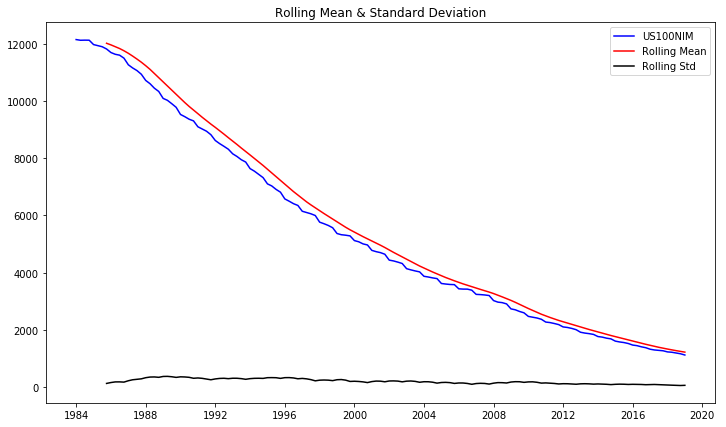

In [73]:
fig = plt.figure(figsize=(12,7))
orig = plt.plot(df2.US100NUM, color='blue',label='US100NIM')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [119]:
## Using learn.co function to play around with USNIM

def stationarity_check(TS, window = 4):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = window, center = False).mean()
    rolstd = TS.rolling(window = window, center = False).std()
   
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

## Checking Stationarity of Net Income (of all banks) over timeline

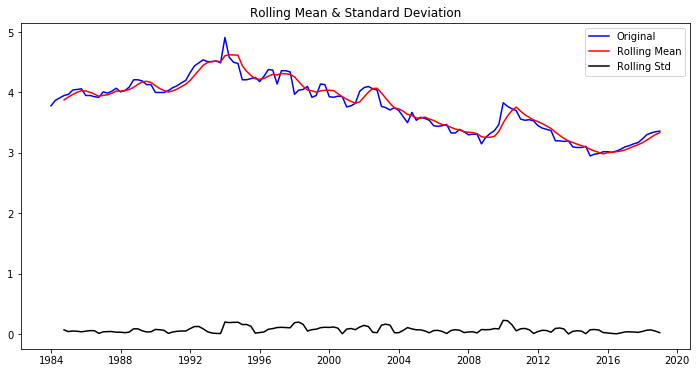

Results of Dickey-Fuller Test:
Test Statistic                  -1.171624
p-value                          0.685682
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (1%)             -3.477945
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
dtype: float64


In [80]:
stationarity_check(df2.USNIM)

In [126]:
USNIM.head()

,USNIM,natural_log
DATE,,
1984-01-01,3.78,1.329724
1984-04-01,3.87,1.353255
1984-07-01,3.91,1.363537
1984-10-01,3.95,1.373716
1985-01-01,3.97,1.378766


### Result indicates Non-Stationarity

Now will explore how to Stationarize this data. Will start with Log Transformation, then differencing. 

In [115]:
USNIM['natural_log'] = np.log(USNIM)

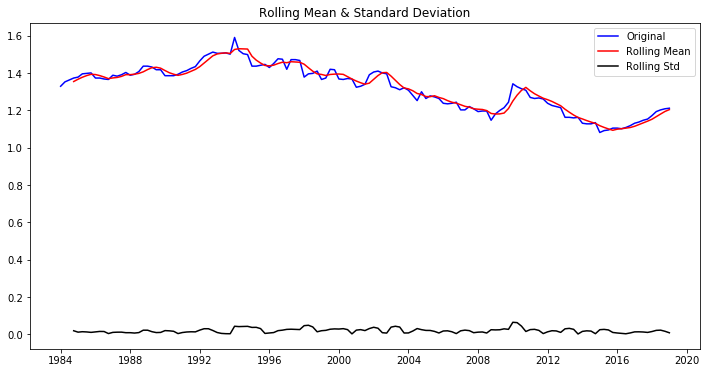

Results of Dickey-Fuller Test:
Test Statistic                  -1.084043
p-value                          0.721393
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (1%)             -3.477945
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
dtype: float64


In [124]:
stationarity_check(USNIM.natural_log)

Log transformation did not have an effect on stationarity. Will try differencing with lag of 4 (annual)

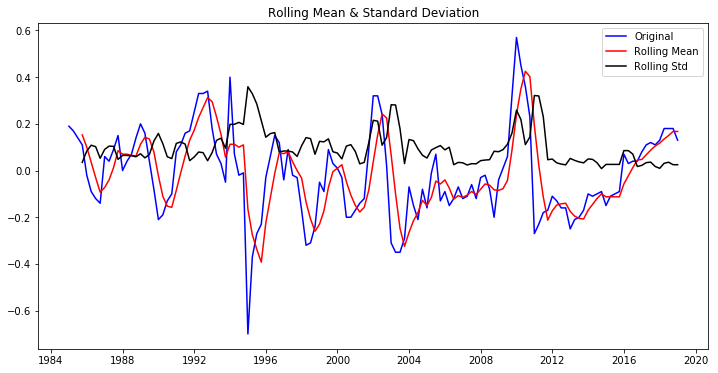

Results of Dickey-Fuller Test:
Test Statistic                  -3.817161
p-value                          0.002737
#Lags Used                       4.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


In [128]:
USNIM['first_difference'] = USNIM.USNIM - USNIM.USNIM.shift(4)  
stationarity_check(USNIM.first_difference.dropna(inplace=False))

## Achieved Stationarity when comparing data annually (lag = 4)

Moving on to fit a model that will address any autocorrelation that remains in the differenced series.

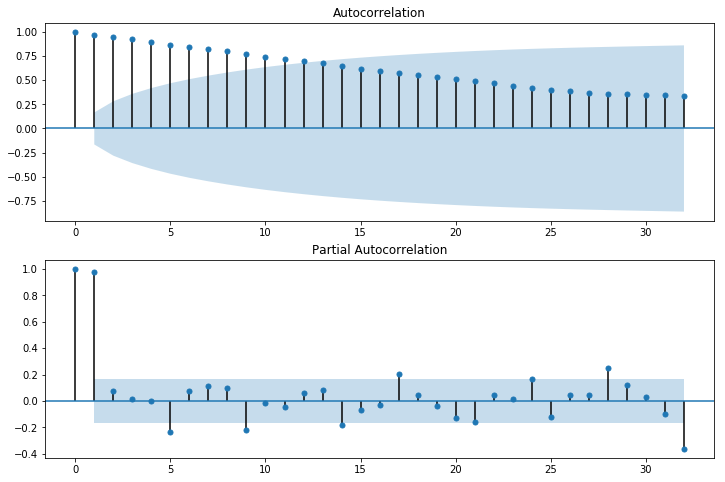

In [135]:
## For the original data

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(USNIM.USNIM.iloc[1:], lags=32, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(USNIM.USNIM.iloc[1:], lags=32, ax=ax2)

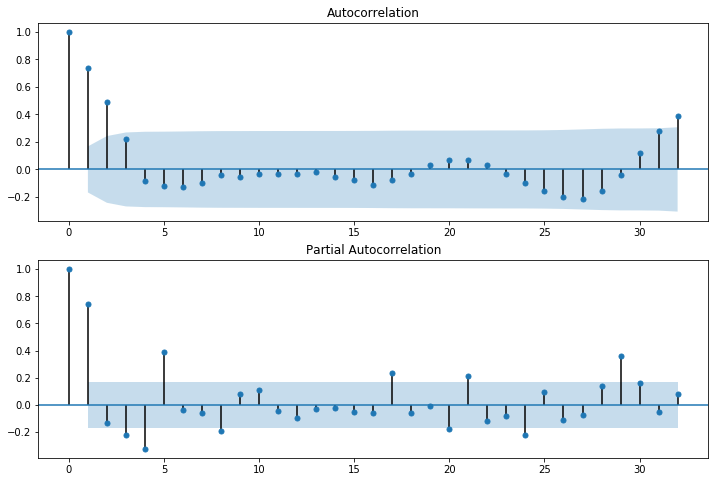

In [141]:
## For the differenced data

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(USNIM.first_difference.iloc[4:], lags=32, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(USNIM.first_difference.iloc[4:], lags=32, ax=ax2)

## Attempting to fit model

In [144]:
mod = sm.tsa.statespace.SARIMAX(USNIM.first_difference, trend='n', order=(0,1,1), seasonal_order=(0,1,1,4), enforce_invertibility = False)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                  first_difference   No. Observations:                  141
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                  39.614
Date:                           Wed, 31 Jul 2019   AIC                            -73.228
Time:                                   09:38:52   BIC                            -64.490
Sample:                               01-01-1984   HQIC                           -69.677
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0157      0.058     -0.269      0.788      -0.130       0.098
ma.S.L4       -1.0000    441.271     -0.002      0.998    -865.874     863.874
sigma2         0.0182      8.053      0.002      0.998     -15.765      15.801
===================================================================================
Ljung-Box (Q):                       95.53   Jarque-Bera (JB):               289.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -1.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

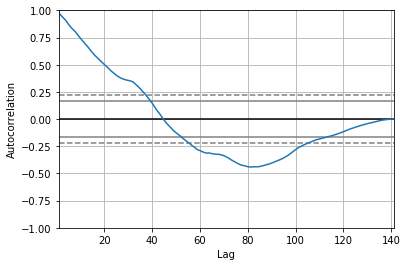

In [82]:
pd.plotting.autocorrelation_plot(np.log(df2.USNIM))

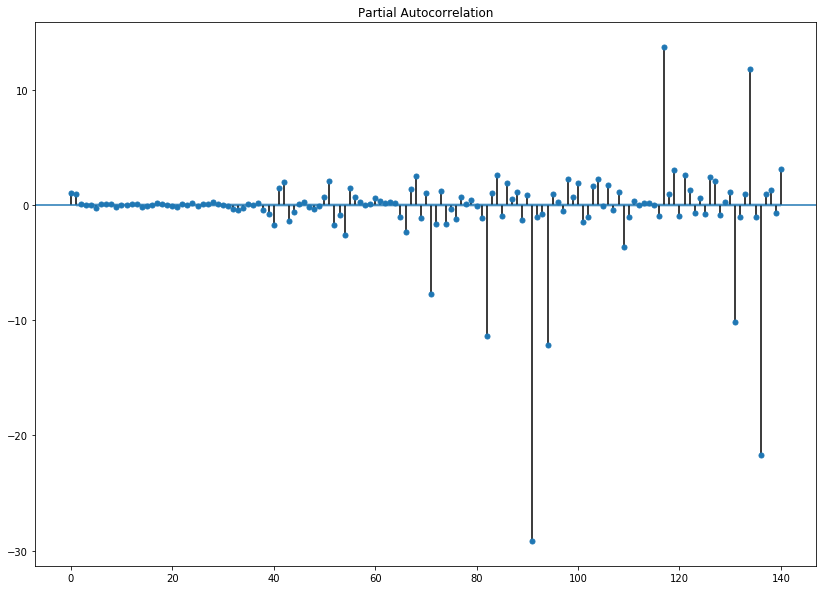

In [89]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 10

plot_pacf(df2.USNIM, lags = 140);

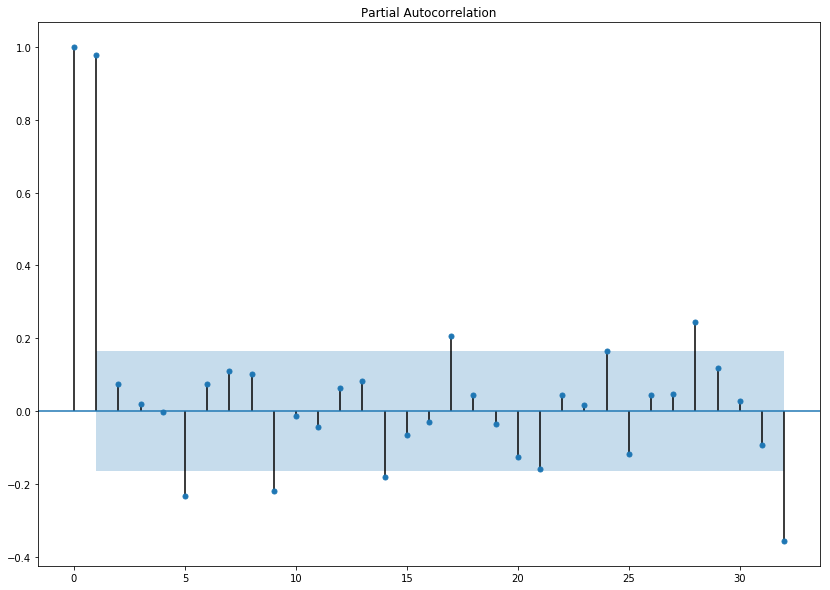

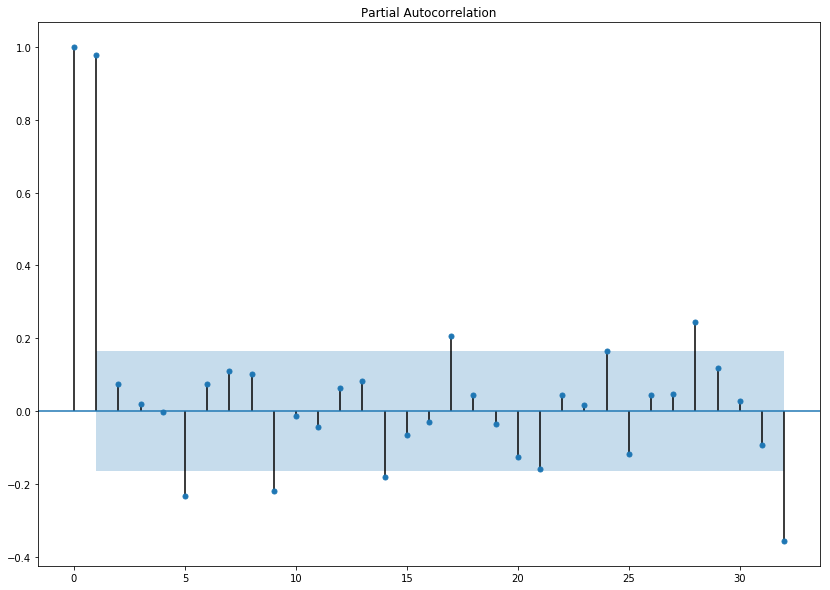

In [98]:
plot_pacf(df2.USNIM, lags = 32)

## Seasonal Decomposition Analysis:



### For all banks Net Income

<Figure size 1008x720 with 0 Axes>

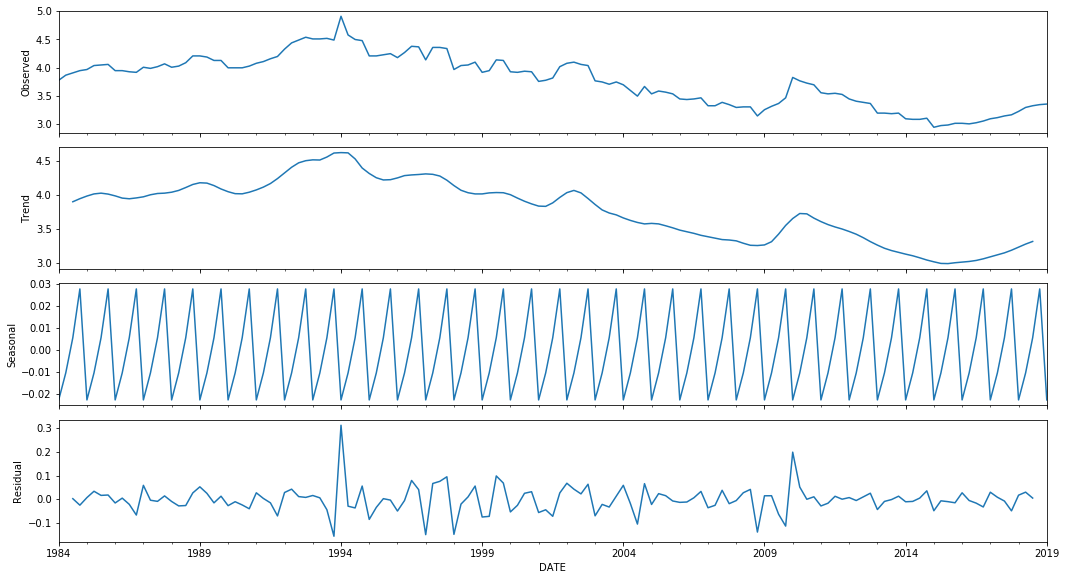

In [153]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2.USNIM, freq=4)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)
fig.savefig('USNIM_SeasonalDecomp.png', dpi=300)

#### Proof that we got rid of seasonality with differencing method:

In [159]:
decomposition4 = seasonal_decompose(USNIM.first_difference.iloc[4:], freq=1)
fig = plt.figure()
fig = decomposition4.plot()
fig.set_size_inches(15, 8)
fig.show();


### For Small Banks Net Income

<Figure size 1008x720 with 0 Axes>

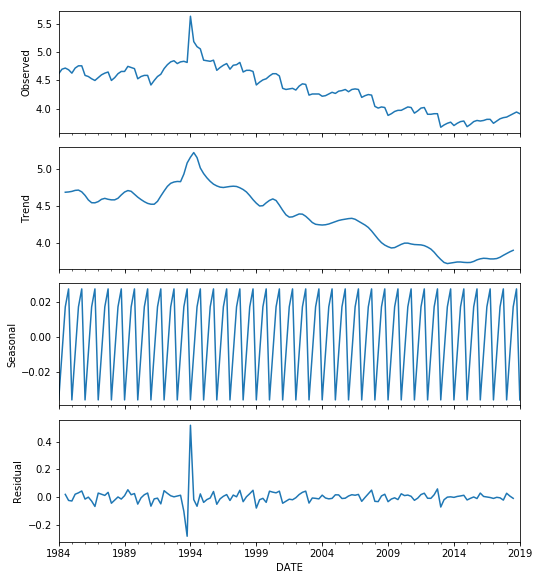

In [167]:
decomposition2 = seasonal_decompose(df2.US100NIM, freq=4)
fig = plt.figure()
fig = decomposition2.plot()
fig.set_size_inches(7, 8)
fig.savefig('US100NIM_SeasonalDecomp.png', dpi=300, pad_inches = 2)
fig.show()

### For Mid-size Bank Net Income

<Figure size 1008x720 with 0 Axes>

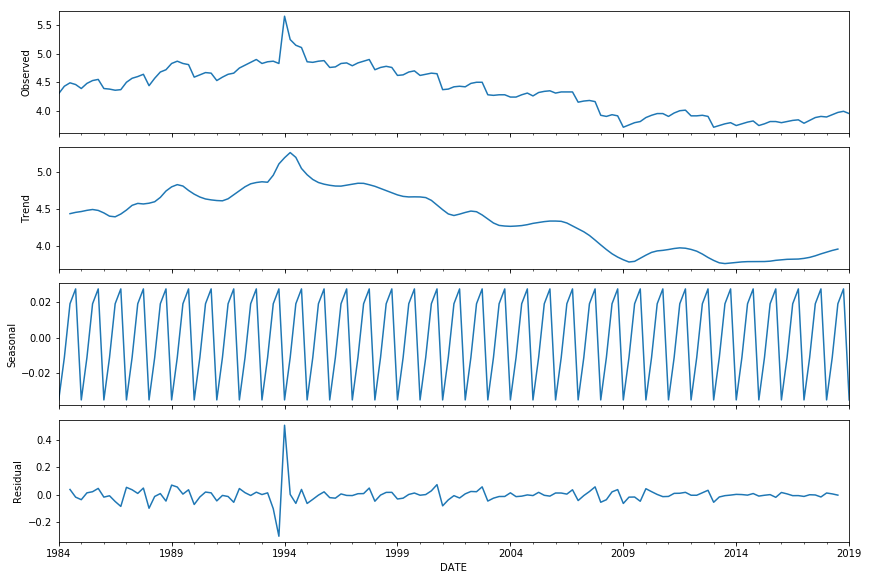

In [165]:
decomposition3 = seasonal_decompose(df2.US13NIM, freq=4)
fig = plt.figure()
fig = decomposition3.plot()
fig.set_size_inches(12, 8)
fig.savefig('US13NIM_SeasonalDecomp.png', dpi=300)
fig.show()

## For Biggest Banks

<Figure size 1008x720 with 0 Axes>

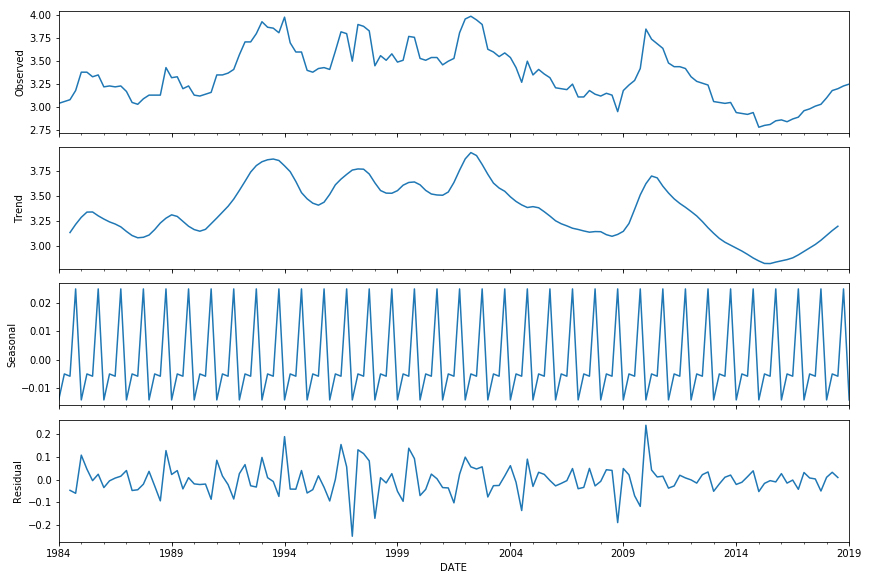

In [168]:
decomposition5 = seasonal_decompose(df2.USG15NIM, freq=4)
fig = plt.figure()
fig = decomposition5.plot()
fig.set_size_inches(12, 8)
#fig.savefig('US13NIM_SeasonalDecomp.png', dpi=300)
fig.show()

<Figure size 1008x720 with 0 Axes>

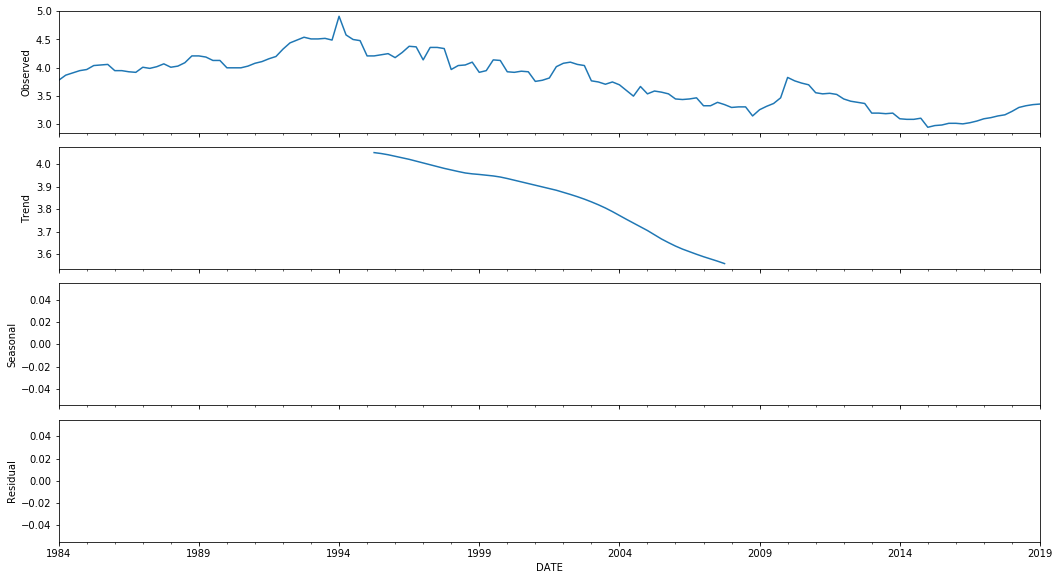

In [92]:
decomposition = seasonal_decompose(df2.USNIM, freq=90)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)